In [11]:
from numpy import array
import pandas as pd
import seaborn as sns
import numpy as np
import math
import matplotlib.pyplot as plt
import datetime as dt
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import xgboost as xgb
from sklearn.model_selection import GridSearchCV

In [12]:
#importing MAC season 4 - days to floering trait file
flowering=pd.read_csv("/Users/ishitadebnath/Desktop/Genomics/MAC season 4/Phenotypes/Modified/mac_season_4_days_gdd_to_flowering.csv" , delimiter=",")
flowering=flowering.rename(columns={"genotype": "cultivar"})

In [13]:
#Importing and merging the gene and trait dataset
dist=pd.read_csv("/Users/ishitadebnath/Desktop/Genomics/cluster.txt", delimiter="\t")
a=dist.X
dist=dist.rename(columns={"X": "cultivar"})
dist=dist.dropna()

flowering=pd.merge(flowering, dist, on="cultivar", how='inner')
print(flowering)

                                              plot  range  column  \
0     MAC Field Scanner Season 4 Range 51 Column 4     51       4   
1     MAC Field Scanner Season 4 Range 10 Column 8     10       8   
2     MAC Field Scanner Season 4 Range 16 Column 7     16       7   
3    MAC Field Scanner Season 4 Range 35 Column 11     35      11   
4     MAC Field Scanner Season 4 Range 50 Column 7     50       7   
..                                             ...    ...     ...   
116   MAC Field Scanner Season 4 Range 46 Column 9     46       9   
117   MAC Field Scanner Season 4 Range 11 Column 8     11       8   
118  MAC Field Scanner Season 4 Range 50 Column 14     50      14   
119  MAC Field Scanner Season 4 Range 20 Column 10     20      10   
120  MAC Field Scanner Season 4 Range 50 Column 12     50      12   

      scientificname  cultivar  \
0    Sorghum bicolor  PI586435   
1    Sorghum bicolor  PI586435   
2    Sorghum bicolor  PI152651   
3    Sorghum bicolor  PI152651   
4

In [4]:
#Creating a feature space and standardizing the features. 

d=flowering.drop(columns=['cultivar','days_to_flowering',  'treatment', 'blocking_height',
       'scientificname','method_type', 'date_of_flowering', 'gdd_to_flowering', 'method','plot','range','column'])

X=d.to_numpy()
min_max_scaler = MinMaxScaler()
X = min_max_scaler.fit_transform(X)

y = flowering[['days_to_flowering']]
y = np.asarray(y).flatten()

(121, 30)


[13:36:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:62.0528	validation_1-rmse:63.2715
[1]	validation_0-rmse:56.1064	validation_1-rmse:57.3421
[2]	validation_0-rmse:50.7691	validation_1-rmse:52.0229
[3]	validation_0-rmse:45.9826	validation_1-rmse:47.2556
[4]	validation_0-rmse:41.6756	validation_1-rmse:42.9624
[5]	validation_0-rmse:37.8003	validation_1-rmse:38.8977
[6]	validation_0-rmse:34.3229	validation_1-rmse:35.4868
[7]	validation_0-rmse:31.1991	validation_1-rmse:32.4455
[8]	validation_0-rmse:28.3611	validation_1-rmse:29.7121
[9]	validation_0-rmse:25.8408	validation_1-rmse:27.346
[10]	validation_0-rmse:23.5325	validation_1-rmse:25.0711
[11]	validation_0-rmse:21.4786	validation_1-rmse:23.0437
[12]	validation_0-rmse:19.6189	validation_1-rmse:21.3168
[13]	validation_0-rmse:17.9337	validation_1-rmse:19.8814
[14]	validation_0-rmse:16.4174	validation_1-rmse:18.5542
[15]	validation_0-rmse:15.047	validation

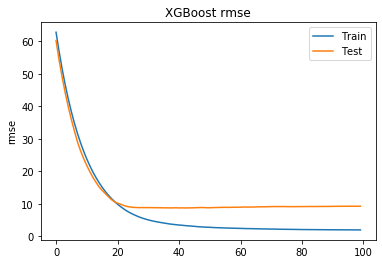

In [5]:
#Performing 5-fold cross validation for Extreme Gradient Boosting

ns=5
groups=flowering.cultivar
cv =GroupKFold(n_splits=ns)
rmse=0
R2=0
e=[]
test=[]
for train_index, test_index in cv.split(X,y,groups):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    
    model=xgb.XGBRegressor()
    xgb.XGBRegressor(booster='gbtree',importance_type='gain', learning_rate=0.7, max_delta_step=0,
       max_depth=5, n_estimators=45, objective='reg:linear', verbosity=1)
    eval_set= [(X_train, y_train), (X_test, y_test)]
    model.fit(X_train, y_train, eval_metric="rmse", eval_set=eval_set, verbose=True)
    print(model.score(X_train,y_train))
    y_pred=model.predict(X_test)
    predictions=[round(value) for value in y_pred]
    rmse=rmse+math.sqrt(mean_squared_error(y_test, y_pred))
    e.append(math.sqrt(mean_squared_error(y_test, y_pred)))
    a = np.c_[predictions, y_test, groups[test_index]]
    test=np.append(test,a)
    print(test.shape)
    
std= (statistics.stdev(e))
print('Root Mean square error for 5-fold CV XG:',rmse/ns, '+-', std)

test=np.array_split(test, 121)
df4 = pd.DataFrame (np.row_stack(test), columns=['Predictions', 'Ground truth','Cultivar'])
df4.to_csv('/Users/ishitadebnath/Desktop/Genomics/Days to flowering MAC season 4/Xgboost.csv',index=False)   
results = model.evals_result()
epochs = len(results['validation_0']['rmse'])
x_axis = range(0, epochs)
# plot log loss
fig, ax = plt.subplots()
ax.plot(x_axis, results['validation_0']['rmse'], label='Train')
ax.plot(x_axis, results['validation_1']['rmse'], label='Test')
ax.legend()
plt.ylabel('rmse')
plt.title('XGBoost rmse')
plt.show()


In [ ]:
# Hyper parameter tuning

[13:37:30] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best: -10.799768 using {'n_estimators': 45}
-13.703718 (2.760647) with: {'n_estimators': 20}
-11.918885 (2.401379) with: {'n_estimators': 25}
-11.250118 (1.952748) with: {'n_estimators': 30}
-10.982733 (1.714557) with: {'n_estimators': 35}
-10.834789 (1.555998) with: {'n_estimators': 40}
-10.799768 (1.509097) with: {'n_estimators': 45}
-10.814543 (1.512319) with: {'n_estimators': 50}
-10.848283 (1.411476) with: {'n_estimators': 55}


Text(0, 0.5, 'RMSE')

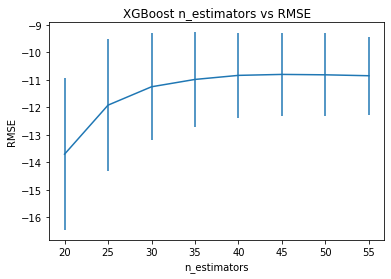

In [10]:
model = xgb.XGBRegressor()
n_estimators = range(20, 60, 5)
param_grid = dict(n_estimators=n_estimators)
kfold = GroupKFold(n_splits=5)
grid_search = GridSearchCV(model, param_grid, scoring="neg_root_mean_squared_error", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, y, groups)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

plt.errorbar(n_estimators, means, yerr=stds)
plt.title("XGBoost n_estimators vs RMSE")
plt.xlabel('n_estimators')
plt.ylabel('RMSE')

[13:36:48] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best: -11.033505 using {'learning_rate': 0.7000000000000001}
-68.834672 (3.334351) with: {'learning_rate': 0.0}
-11.043615 (1.330100) with: {'learning_rate': 0.1}
-11.104984 (1.262178) with: {'learning_rate': 0.2}
-11.174241 (1.029114) with: {'learning_rate': 0.30000000000000004}
-11.068646 (1.456525) with: {'learning_rate': 0.4}
-11.088116 (1.379529) with: {'learning_rate': 0.5}
-11.596408 (1.727665) with: {'learning_rate': 0.6000000000000001}
-11.033505 (1.503321) with: {'learning_rate': 0.7000000000000001}
-12.766843 (1.874586) with: {'learning_rate': 0.8}
-13.052389 (1.054937) with: {'learning_rate': 0.9}
-12.780060 (0.813172) with: {'learning_rate': 1.0}


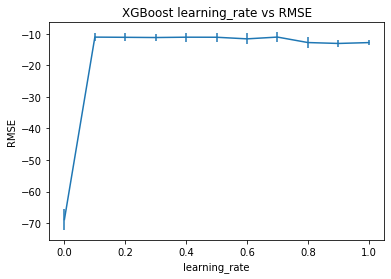

In [7]:
model = xgb.XGBRegressor()
learning_rate = np.linspace(0,1,11)
param_grid = dict(learning_rate=learning_rate)
kfold = GroupKFold(n_splits=5)
grid_search = GridSearchCV(model, param_grid, scoring="neg_root_mean_squared_error", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, y, groups)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

plt.errorbar(learning_rate, means, yerr=stds)
plt.title("XGBoost learning_rate vs RMSE")
plt.xlabel('learning_rate')
plt.ylabel('RMSE')
plt.savefig('learning_rate.png')

range(1, 20, 2)
[13:36:49] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best: -10.978422 using {'max_depth': 5}
-11.284399 (1.561470) with: {'max_depth': 1}
-11.043615 (1.330100) with: {'max_depth': 3}
-10.978422 (1.572450) with: {'max_depth': 5}
-11.188897 (1.452907) with: {'max_depth': 7}
-11.169440 (1.468796) with: {'max_depth': 9}
-11.135823 (1.472944) with: {'max_depth': 11}
-11.160119 (1.462194) with: {'max_depth': 13}
-11.142132 (1.470142) with: {'max_depth': 15}
-11.142044 (1.470264) with: {'max_depth': 17}
-11.142044 (1.470264) with: {'max_depth': 19}


Text(0, 0.5, 'RMSE')

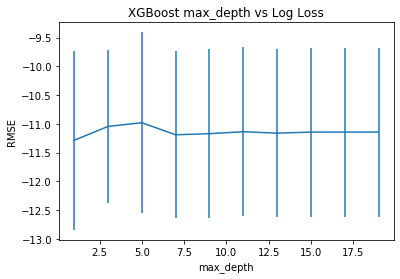

In [8]:
model = xgb.XGBRegressor()
max_depth = range(1, 20, 2)
print(max_depth)
param_grid = dict(max_depth=max_depth)
kfold = GroupKFold(n_splits=5)
grid_search = GridSearchCV(model, param_grid, scoring="neg_root_mean_squared_error", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, y, groups)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

plt.errorbar(max_depth, means, yerr=stds)
plt.title("XGBoost max_depth vs Log Loss")
plt.xlabel('max_depth')
plt.ylabel('RMSE')

[13:36:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Best: -10.799623 using {'max_depth': 5, 'n_estimators': 40}
-13.410660 (3.023602) with: {'max_depth': 1, 'n_estimators': 20}
-11.644526 (2.413869) with: {'max_depth': 1, 'n_estimators': 25}
-11.083718 (1.913121) with: {'max_depth': 1, 'n_estimators': 30}
-10.921784 (1.647832) with: {'max_depth': 1, 'n_estimators': 35}
-10.921779 (1.452085) with: {'max_depth': 1, 'n_estimators': 40}
-10.946164 (1.385701) with: {'max_depth': 1, 'n_estimators': 45}
-13.703718 (2.760647) with: {'max_depth': 3, 'n_estimators': 20}
-11.918885 (2.401379) with: {'max_depth': 3, 'n_estimators': 25}
-11.250118 (1.952748) with: {'max_depth': 3, 'n_estimators': 30}
-10.982733 (1.714557) with: {'max_depth': 3, 'n_estimators': 35}
-10.834789 (1.555998) with: {'max_depth': 3, 'n_estimators': 40}
-10.799768 (1.509097) with: {'max_depth': 3, 'n_estimators': 45}
-13.872069 (2.974633) with: {'max_depth': 5,

Text(0, 0.5, 'RMSE')

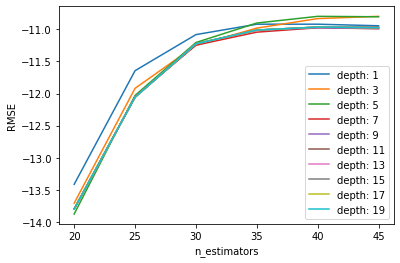

In [9]:
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
kfold = GroupKFold(n_splits=5)
grid_search = GridSearchCV(model, param_grid, scoring="neg_root_mean_squared_error", n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X, y, groups)

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

scores = np.array(means).reshape(len(max_depth), len(n_estimators))
for i, value in enumerate(max_depth):
    plt.plot(n_estimators, scores[i], label='depth: ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('RMSE')
